<a href="https://colab.research.google.com/github/tuphr2234/ChaosPrediction/blob/main/ThreeBodySimulation_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build Simulation

In [ ]:
pip install anvil-uplink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.3 MB/s 
     |████████████████████████████████| 51 kB 258 kB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=2defbc6ac649207798be65c62b24123cf1de8c3a95da2cde33aeb3c43c3f81cc
  Stored in directory: /root/.cache/pip/wheels/29/ea/7d/3410aa0aa0e4402ead9a7a97ab2214804887e0f5c2b76f0c96
Successfully built ws4py


In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf
import os
from pathlib import Path  


G=1


class Body:
  
  prevPosition=np.array([0,0])
  position=np.array([0,0])
  velocity=np.array([0,0])
  force=np.array([0,0])
  acceleration=np.array([0,0])
  mass=0

  def __init__(self,position,velocity,mass,name):
    self.position=np.array(position)
    self.velocity=np.array(velocity)
    #self.acceleration=np.array(acceleration)
    self.mass=mass
    self.prevPosition=np.array(position)
    self.name = name


  def setInitialPostion(self,position):
    self.postion = np.array(position)

    
  def setInitialVelocity(self,velocity):
    self.velocity = np.array(velocity)

   
  def setInitialMass(self,mass):
    self.mass = mass




  def setPosition(self,t):
    self.prevPosition = self.position
    self.position=self.position+self.velocity*t+(self.acceleration/2)* t**2
  

  def setVelocity(self,t):
    self.velocity=self.velocity+self.acceleration*t
  

  def getForce(self,body):
    softening = 0.01
    Distance = body.prevPosition - self.position
    Rsquare = Distance[0]**2 + Distance[1]**2 + softening
    F = G* self.mass*body.mass / Rsquare  
    normalizeDis = Distance / math.sqrt(Rsquare)
    F = F*normalizeDis
    if math.sqrt(Rsquare) < softening:
      F = -F 
    #print(f"body {self.name} force is {F} ")
    
    return F

  def setAcceleration(self,bodies):
    F=np.array([0,0])
    for body in bodies:
      F=F+self.getForce(body)
    self.acceleration = F/self.mass
   # print(f" {self.name} acceleration is {self.acceleration}")

In [ ]:

def simulateOnTimeStep(bodies,t,steps,interval_in_data): # bodies: list of bodies. t: timestep . steps: number of steps. interval_in_data : frequency of rows taken to dataset: if equals 1 than it is every step
  dataset = []

  for i in range(steps):
      list1=[]
      for body in bodies:
        list1.append(body.position)
      if i % interval_in_data ==0:
        dataset += list1
      
      for i,body in enumerate(bodies):
        body.setAcceleration([b for b in bodies if b is not body])
        body.setVelocity(t)
        body.setPosition(t)
       
        
      for body in bodies:
        body.prevPosition = body.position
    

  return np.array(dataset).reshape(steps//interval_in_data,len(bodies),2)



In [ ]:
def numpyToPandas(simulation,numOfBodies):
  columns = []

  for i in range(numOfBodies):
    columns.append(f'Body{i+1} x')
    columns.append(f'Body{i+1} y')
  simulation_reshaped = simulation.reshape(len(simulation), numOfBodies*2 )

  df = pd.DataFrame(simulation_reshaped, columns = columns)
  return df


Add Filters

In [ ]:
def addNoise(simulation):
  noise = np.random.normal(0, .1, simulation.shape)
  return simulation + noise
def removeBody(simulation, bodyNum):
  del1 = np.delete(simulation,(bodyNum-1)*2,1)
  return np.delete(del1,(bodyNum-1)*2,1)

Save Simulation

In [ ]:
## save simulation as csv
def saveSimulation(simulation,numOfBodies,simulation_name):
  df = numpyToPandas(simulation,numOfBodies) 
  df.to_csv(f'/content/{simulation_name}.csv',index=False)
  
def loadSimulation(df):
  return pd.DataFrame.to_numpy(df)  

Prepare Dataset 

In [ ]:
def prepareData(simulation,window_size_X):
  X = []
  y = []
  for i in range(len(simulation)-window_size_X):
    row = [bodies for bodies in simulation[i:i+window_size_X]]  ### adding time is an option
    X.append(row)
    label = simulation[i+window_size_X]
    y.append(label)
  return np.array(X) , np.array(y)  

In [ ]:
def prepareData2(simulation,window_size_X,window_size_y): 
  X = []
  y = []
  for i in range(len(simulation)-window_size_X - window_size_y):
    row = [bodies for bodies in simulation[i:i+window_size_X]]  
    X.append(row)
    label =  [bodies for bodies in simulation[i+window_size_X:i+window_size_X + window_size_y]]#######################################
    y.append(label)

  return np.array(X) , np.array(y)


In [ ]:
def splitToTrainValidTest(dataset,testPercentage):
  trainLen = round((len(dataset)*(1-testPercentage-0.05)))
  valLen = round((len(dataset)*0.05))
  train_set = dataset[:trainLen]
  val_set = dataset[trainLen:trainLen+valLen]
  test_set = dataset[trainLen+valLen:]
  return train_set,val_set,test_set

In [ ]:
def drawSimulation(simulation):
  prev = np.copy(simulation[0])
  numOfBodies = len(simulation[0])
  colors = ['red','green','blue','yellow','black']
  for i,sim in enumerate(simulation):
    if i == 0:
      continue
    for j in range(0,len(sim),2):
      plt.plot([prev[j],sim[j]],[prev[j+1],sim[j+1]],  color = colors[j // 2])
      prev[j] = np.copy(sim[j])
      prev[j+1] = np.copy(sim[j+1])
  plt.show()


In [ ]:
def showBodiesMovmentInGraph(simulation):
  plt.title("X body coordinate")
  for i in range(0,len(simulation.columns),2):
      df = simulation.iloc[:,i]
      plt.plot(df)
  plt.show()
  plt.title("Y body coordinate")
  for i in range(1,len(simulation.columns),2):
      df = simulation.iloc[:,i]
      plt.plot(df)
  plt.show()




Preprocessing/Postprocessing

Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

def buildModelCNN(window_size_X,numberOfBodies): ### One step at a time - autoreggresive model 
  model = Sequential()
  model.add(InputLayer((window_size_X,numberOfBodies*2)))#model.add(InputLayer((window_size_X,numberOfBodies*2)))
  model.add(Conv1D(64, kernel_size=2))
  #model.add(Dropout(0.2))
  model.add(Conv1D(32, kernel_size=2))
  #model.add(TimeDistributed(conv_1d))
  model.add(Flatten())
  #model.add(LSTM(32))
  #model.add(Dropout(0.2))
  model.add(Dense(16, 'relu'))
  model.add(Dense(numberOfBodies*2, 'linear'))
  model.summary()
  return model



def buildModelCNN2(window_size_X,window_size_y,numberOfBodies): ### Multiple predictions at a time
  model = Sequential()
  model.add(InputLayer((window_size_X,numberOfBodies*2)))#model.add(InputLayer((window_size_X,numberOfBodies*2)))
  #model.add(Conv1D(64, kernel_size=2)) ###
  #model.add(Dropout(0.2))
  model.add(Conv1D(32, kernel_size=2)) ###
  #model.add(TimeDistributed(conv_1d))
  model.add(Flatten())
  #model.add(LSTM(32))
  #model.add(Dropout(0.2))
  model.add(Dense(16, 'relu'))
  model.add(Dense(units =  window_size_y*numberOfBodies*2, activation ='linear'))
  model.add(tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))
  model.summary()
  return model

In [ ]:
def preprocessSimulation(simulation):
  shape = simulation[0].shape
  newSimulation = np.append(simulation[1:],[np.zeros(shape)],axis=0) - simulation
  newSimulation = newSimulation[:-1]
  #for i,s in enumerate(newSimulation):
  #  s = s / np.linalg.norm(simulation[i])
  return newSimulation

In [ ]:
def postprocess(lastKnownElement , listOfPredictedChanges):
  listOfPredictions = []
  for pred in listOfPredictedChanges:
    #newElement = (pred * np.linalg.norm(lastKnownElement)) + lastKnownElement
    newElement = pred  + lastKnownElement
    listOfPredictions.append(newElement)
    lastKnownElement = newElement
  return np.array(listOfPredictions)  


Training Model

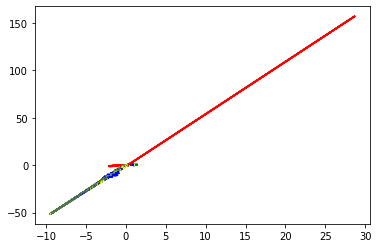

In [ ]:
#Body(position,velocity,mass,name)
#%%timeit
divFactor = 100
bodies=[]

bodies.append(Body([0.97000436,-0.24308753],[0.466203685,0.45236573],1,"body1"))
bodies.append(Body([-0.97000436,0.24308753],[0.466203685,0.41236573],1,"body2"))
bodies.append(Body([0, 0],[-0.93240737,-0.84473146],1,"body3"))
bodies.append(Body([0.3, 0.24308753],[0, 0],1,"body4"))


#bodies.append(Body([0.26000000000000023,-0.16999999999999993],[0.18000000000000016,0.1499999999999999],1,"body1"))
#bodies.append(Body([0.18000000000000016,0.14000000000000012],[0,0.33000000000000007],1,"body2"))
#bodies.append(Body([0.18000000000000016,0.27],[0.18000000000000016,0.20000000000000018],1,"body3"))


######

# The 8 Figure motion initials

 #r1(0) = −r3(0) = (−0.97000436, 0.24308753);
 # r2(0) = (0,0); v1(0) = v3(0) = (0.4662036850, 0.4323657300);
 # v2(0) = (−0.93240737, −0.86473146). The values are obtained from Chenciner & Montgomery (2000).


########

numOfBodies=len(bodies)
##t: timestep . steps: number of steps. interval_in_data
timestep = 0.0001 # actual seconds
steps = 1220000
#steps = 3000000
interval_in_data = 500

simulation1 = simulateOnTimeStep(bodies,timestep,steps,interval_in_data)
simulation1=simulation1.reshape(len(simulation1), numOfBodies*2 )
saveSimulation(simulation1,numOfBodies,f"{numOfBodies}-Body Simulation")
drawSimulation(simulation1)

In [ ]:
simulation1 = simulation1[:,2:8]

In [ ]:
simulation1.shape

(2440, 6)

In [ ]:
numOfBodies = simulation1.shape[1] // 2

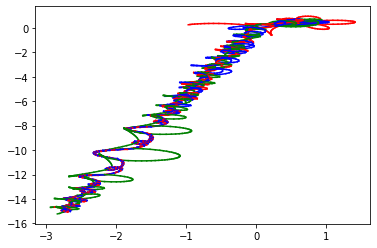

In [ ]:
drawSimulation(simulation1[0:800])

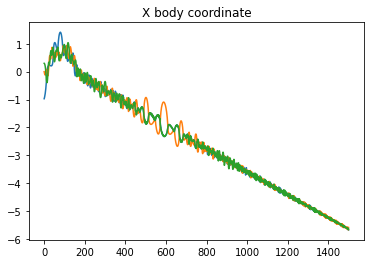

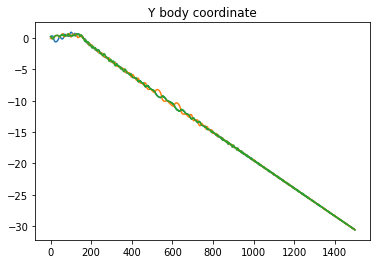

In [ ]:
showBodiesMovmentInGraph(numpyToPandas(simulation1[:1500],numOfBodies))

In [ ]:
simulation1 = loadSimulation(pd.read_csv(f'/content/{numOfBodies}-Body Simulation.csv'))

In [ ]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.signal import hilbert
scaled = False 

batch = 128

diffSimulation1 = np.diff(simulation1[:1000],axis = 0)
#diffSimulation1 = np.diff(simulation1[:,2:8],axis = 0)
train, val, test = splitToTrainValidTest(diffSimulation1,0.2)


windowSizeX=100
windowSizeY =100




if scaled:
  scaler = StandardScaler()
  scaler.fit(simulation1[:len(train)+len(val)])
  #valScaler.fit(train)  ### train / val as input ? 

  train = scaler.transform(train)
  val = scaler.transform(val)
  #train = hilbert(train)
  #val = hilbert(val)
#y_train = scaler.fit(train)

#train = preprocessSimulation(train)
#val = preprocessSimulation(val)



#train2, val2, test2 = splitToTrainValidTest(simulation2,0.2)


#X_train, y_train = prepareData(train,windowSizeX)
#X_val, y_val = prepareData(val,windowSizeX)
#X_test, y_test = prepareData(test,windowSizeX)


X_train, y_train = prepareData2(train,windowSizeX,windowSizeY)
X_val, y_val = prepareData2(val,windowSizeX,windowSizeY)
X_test, y_test = prepareData2(test,windowSizeX,windowSizeY)


model =  buildModelCNN2(windowSizeX,windowSizeY,numOfBodies)
cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])


#X_train2, y_train2 = prepareData(train2,windowSizeX)
#X_val2, y_val2 = prepareData(val2,windowSizeX)
#X_tes2t, y_test2 = prepareData(test2,windowSizeX)

#generator = TimeseriesGenerator(train_scaled,train_scaled,length = len(test),batch_size=batch)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 99, 32)            416       
                                                                 
 flatten_2 (Flatten)         (None, 3168)              0         
                                                                 
 dense_4 (Dense)             (None, 16)                50704     
                                                                 
 dense_5 (Dense)             (None, 600)               10200     
                                                                 
 reshape_2 (Reshape)         (None, 100, 6)            0         
                                                                 
Total params: 61,320
Trainable params: 61,320
Non-trainable params: 0
_________________________________________________________________


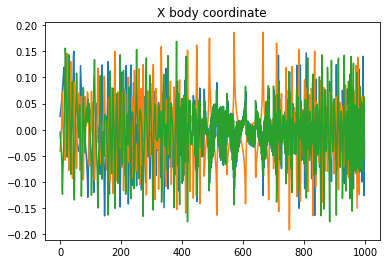

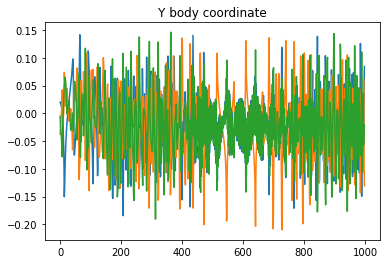

In [ ]:
showBodiesMovmentInGraph(numpyToPandas(diffSimulation1,numOfBodies))

In [ ]:
#for i in range(100):
  #model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, callbacks=[cp1])
  #model.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=2, callbacks=[cp1])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, callbacks=[cp1])

Epoch 1/150
18/18 [==============================] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0537

18/18 [==============================] - 0s 7ms/step - loss: 0.0029 - root_mean_squared_error: 0.0537
Epoch 2/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0523

18/18 [==============================] - 0s 4ms/step - loss: 0.0027 - root_mean_squared_error: 0.0523
Epoch 3/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0513

18/18 [==============================] - 0s 4ms/step - loss: 0.0027 - root_mean_squared_error: 0.0521
Epoch 4/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0516

18/18 [==============================] - 0s 4ms/step - loss: 0.0027 - root_mean_squared_error: 0.0518
Epoch 5/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0503

18/18 [==============================] - 0s 4ms/step - loss: 0.0026 - root_mean_squared_error: 0.0513
Epoch 6/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0508

18/18 [==============================] - 0s 4ms/step - loss: 0.0026 - root_mean_squared_error: 0.0506
Epoch 7/150
15/18 [========================>.....] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0498

18/18 [==============================] - 0s 5ms/step - loss: 0.0025 - root_mean_squared_error: 0.0498
Epoch 8/150
16/18 [=========================>....] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0490

18/18 [==============================] - 0s 5ms/step - loss: 0.0024 - root_mean_squared_error: 0.0489
Epoch 9/150
18/18 [==============================] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0482

18/18 [==============================] - 0s 4ms/step - loss: 0.0023 - root_mean_squared_error: 0.0482
Epoch 10/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0463

18/18 [==============================] - 0s 4ms/step - loss: 0.0023 - root_mean_squared_error: 0.0476
Epoch 11/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0483

18/18 [==============================] - 0s 4ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471
Epoch 12/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0465

18/18 [==============================] - 0s 4ms/step - loss: 0.0022 - root_mean_squared_error: 0.0467
Epoch 13/150
17/18 [===========================>..] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0462

18/18 [==============================] - 0s 4ms/step - loss: 0.0021 - root_mean_squared_error: 0.0462
Epoch 14/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0456

18/18 [==============================] - 0s 4ms/step - loss: 0.0021 - root_mean_squared_error: 0.0458
Epoch 15/150
18/18 [==============================] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0454

18/18 [==============================] - 0s 4ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454
Epoch 16/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0444

18/18 [==============================] - 0s 4ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451
Epoch 17/150
17/18 [===========================>..] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0448

18/18 [==============================] - 0s 4ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448
Epoch 18/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

18/18 [==============================] - 0s 4ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445
Epoch 19/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0433

18/18 [==============================] - 0s 4ms/step - loss: 0.0020 - root_mean_squared_error: 0.0443
Epoch 20/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0444

18/18 [==============================] - 0s 4ms/step - loss: 0.0019 - root_mean_squared_error: 0.0441
Epoch 21/150
16/18 [=========================>....] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0440

18/18 [==============================] - 0s 5ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439
Epoch 22/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0436

18/18 [==============================] - 0s 4ms/step - loss: 0.0019 - root_mean_squared_error: 0.0437
Epoch 23/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0432

18/18 [==============================] - 0s 4ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435
Epoch 24/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0434

18/18 [==============================] - 0s 4ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435
Epoch 25/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0431

18/18 [==============================] - 0s 4ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433
Epoch 26/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0432

18/18 [==============================] - 0s 4ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433
Epoch 27/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0436

18/18 [==============================] - 0s 4ms/step - loss: 0.0019 - root_mean_squared_error: 0.0431
Epoch 28/150
18/18 [==============================] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0430

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0430
Epoch 29/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0421

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0430
Epoch 30/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0425

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0429
Epoch 31/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0418

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428
Epoch 32/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0419

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427
Epoch 33/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0425

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427
Epoch 34/150
18/18 [==============================] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0426

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426
Epoch 35/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0422

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426
Epoch 36/150
18/18 [==============================] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0426

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426
Epoch 37/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0425

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0425
Epoch 38/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0445

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0425
Epoch 39/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424
Epoch 40/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0398

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424
Epoch 41/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0422

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424
Epoch 42/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0424

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423
Epoch 43/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0430

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423
Epoch 44/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0436

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423
Epoch 45/150
18/18 [==============================] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0423

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423
Epoch 46/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0439

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422
Epoch 47/150
18/18 [==============================] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0422

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422
Epoch 48/150
18/18 [==============================] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0422

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422
Epoch 49/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0417

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422
Epoch 50/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0437

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421
Epoch 51/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0429

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421
Epoch 52/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0412

18/18 [==============================] - 0s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421
Epoch 53/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0423

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421
Epoch 54/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0403

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421
Epoch 55/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0436

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421
Epoch 56/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0414

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420
Epoch 57/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421
Epoch 58/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0423

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420
Epoch 59/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0435

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420
Epoch 60/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0418

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420
Epoch 61/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0407

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420
Epoch 62/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0409

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420
Epoch 63/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0406

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419
Epoch 64/150
18/18 [==============================] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0419

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419
Epoch 65/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0417

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419
Epoch 66/150
18/18 [==============================] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0419

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419
Epoch 67/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0440

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419
Epoch 68/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0408

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419
Epoch 69/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0418
Epoch 70/150
18/18 [==============================] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0418

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0418
Epoch 71/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0416

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0418
Epoch 72/150
18/18 [==============================] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0419

18/18 [==============================] - 0s 5ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419
Epoch 73/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0425

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0418
Epoch 74/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0418
Epoch 75/150
18/18 [==============================] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0418

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0418
Epoch 76/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0417

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0418
Epoch 77/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0414

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0418
Epoch 78/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0422

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0418
Epoch 79/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0412

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0418
Epoch 80/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0408

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0418
Epoch 81/150
18/18 [==============================] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0417

18/18 [==============================] - 0s 5ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 82/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0401

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 83/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0402

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 84/150
18/18 [==============================] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0417

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 85/150
15/18 [========================>.....] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0416

18/18 [==============================] - 0s 5ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 86/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0410

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 87/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0393

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 88/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0419

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 89/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0414

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 90/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0422

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0418
Epoch 91/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0399

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 92/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0420

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 93/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0420

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 94/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0412

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416
Epoch 95/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0416

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 96/150
17/18 [===========================>..] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0417

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 97/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0423

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416
Epoch 98/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0404

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 99/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0418

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416
Epoch 100/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0402

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416
Epoch 101/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0408

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416
Epoch 102/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0404

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416
Epoch 103/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0419

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416
Epoch 104/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0422

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 105/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0424

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 106/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0421

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 107/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0422

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416
Epoch 108/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0424

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 109/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0412

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416
Epoch 110/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0422

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416
Epoch 111/150
18/18 [==============================] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0416

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416
Epoch 112/150
18/18 [==============================] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 113/150
16/18 [=========================>....] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0417

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416
Epoch 114/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0410

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416
Epoch 115/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0413

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 116/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0417

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 117/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0404

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 118/150
18/18 [==============================] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 119/150
17/18 [===========================>..] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 120/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0425

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 121/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0401

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 122/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0425

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 123/150
16/18 [=========================>....] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0416

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 124/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0431

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 125/150
18/18 [==============================] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 126/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0394

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 127/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0435

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 128/150
18/18 [==============================] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 129/150
18/18 [==============================] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 130/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0420

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 131/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0407

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 132/150
18/18 [==============================] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 133/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0404

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 134/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0405

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 135/150
14/18 [======================>.......] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

18/18 [==============================] - 0s 5ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414
Epoch 136/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0417

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414
Epoch 137/150
17/18 [===========================>..] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 138/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0442

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 139/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0402

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414
Epoch 140/150
17/18 [===========================>..] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0414

18/18 [==============================] - 0s 5ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414
Epoch 141/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0410

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414
Epoch 142/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0422

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414
Epoch 143/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0420

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 144/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0417

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 145/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0403

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414
Epoch 146/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0414

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414
Epoch 147/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0403

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415
Epoch 148/150
17/18 [===========================>..] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414
Epoch 149/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0393

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414
Epoch 150/150
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0413

18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414


KeyError: ignored

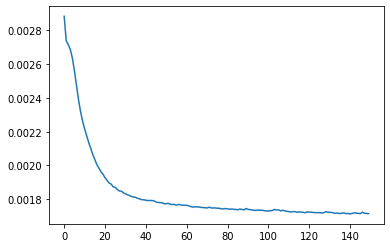

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#history = model.fit_generator(generator,epochs=100,verbose=1)

Predictions

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
predictions = model.predict(X_test)          ###############  LOCAL RMSE  (prediction per window on test set)
#predictions = postprocess(val[-1],predictions)
#predictions = scaler.inverse_transform(predictions)
#print(math.sqrt(mean_squared_error(y_test,predictions)))
print(math.sqrt(mean_squared_error(y_test.reshape(len(X_test),windowSizeY*numOfBodies*2),predictions.reshape(len(X_test),windowSizeY*numOfBodies*2))))


In [ ]:
predictions = model.predict(X_train[-1:])
predictions=predictions.squeeze()
predictions.shape
#print(math.sqrt(mean_squared_error(predictions,val)))


(100, 6)

In [ ]:
def slidingWindowActualPredictions(model,windowArr,windowSize,NumOfBodies,predictionsRequestedNumber): ### One step at a time autoregresion
  

  actualPredictionArr =[]
  for i in range(predictionsRequestedNumber):

    prediction = model.predict(windowArr[-1:]) ### predict from last window
    actualPredictionArr.append(prediction)
    temp = np.zeros([windowSize,numOfBodies*2])
    temp = temp + windowArr[-1]
    temp =temp[1:]
    newWindow = np.append(temp.reshape(windowSize-1,numOfBodies*2),prediction)
    newWindow = newWindow.reshape(windowSize,numOfBodies*2)
    lengthX = len(windowArr)
    windowArr = np.append(windowArr,newWindow) ### add new window that the last vector is the prediction 
    windowArr = windowArr.reshape(lengthX+1,windowSize,numOfBodies*2)

  return actualPredictionArr

In [ ]:
%%script false

import math

listOfPredictions = slidingWindowActualPredictions(model,X_train,windowSizeX,numOfBodies,len(val)+len(test))
listOfPredictions =np.array(listOfPredictions)
listOfPredictions = listOfPredictions.squeeze()

listOfPredictionsTrue = postprocess(simulation1[len(X_train)+windowSizeX-1],listOfPredictions)

if scaled:
  listOfPredictionsTrue = scaler.inverse_transform(listOfPredictionsTrue)


In [ ]:
actualPredictions = postprocess(simulation1[len(X_train)+windowSizeX-1],predictions)

In [ ]:
#print(math.sqrt(mean_squared_error(simulation1[len(X_train)+windowSizeX+1:],listOfPredictionsTrue))) ##### ACTUAL RMSE #####
print(math.sqrt(mean_squared_error(postprocess(simulation1[len(X_train)+windowSizeX-1],val[:100]),actualPredictions))) ##### ACTUAL RMSE #####


ValueError: ignored

In [ ]:
%%script false

print((diffSimulation1[len(X_train)+windowSizeX-1]))

print((train[-1:]))

print(listOfPredictions[0])
if scaled:
  print((scaler.inverse_transform(model.predict(X_train[-1:]))))

In [ ]:
#%%script false

import matplotlib.pyplot as plt
disArr = []
#for i in range(len(val)+len(test)):
  #disArr.append(np.linalg.norm(simulation1[len(X_train)+windowSizeX+i+1]-listOfPredictionsTrue[i]))
for i in range(len(val)):
  disArr.append(np.linalg.norm(postprocess(simulation1[len(X_train)+windowSizeX-1],val)[i]-actualPredictions[i]))

plt.plot(disArr)  

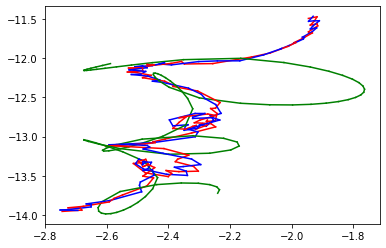

In [ ]:
#drawSimulation(simulation1[len(X_train)+windowSizeX+2:len(X_train)+windowSizeX+31])
drawSimulation(simulation1[len(X_train)+windowSizeX+1 : len(X_train)+windowSizeX + 100])

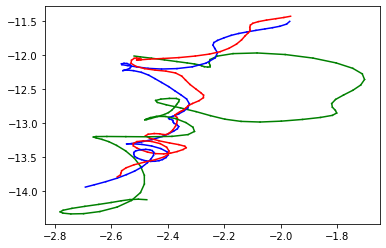

In [ ]:
#drawSimulation(listOfPredictionsTrue[1:30])
drawSimulation(actualPredictions)